This is the part-2 of scripting in Visum tutorial. If you haven't already, you can check the part-1 of this tutorial [here](scripting_in_Visum_part_1.ipynb)

I will cover the follwing topics in this tutorial
* <a href = '#scenario-management' style = 'text-decoration:none'>Creating Scenario Management</a>
* <a href = '#modifications-and-scenarios' style = 'text-decoration:none'>Adding new Modifications and Scenarios</a>
* <a href = '#updating-modifications' style = 'text-decoration:none'>Updating Modifications</a>
* <a href = '#extracting-results' style = 'text-decoration:none'>Extracting Results</a>

In [1]:
#importing required libraries
import win32com.client as com
import pandas as pd
import time  #useful while extracting the results
from IPython.display import Image, display

#to print the network
def printNetwork(imageName):
    Visum.Graphic.DisplayEntireNetwork()
    loc = f"C:/Users/pamidiashoka/Desktop/visum/images/{imageName}.png"
    Visum.Graphic.Screenshot(loc, screenResFactor=1)
    display(Image(loc))

In [2]:
Visum = com.Dispatch("Visum.Visum")  #creatig an instance of Visum

#### <a id = "scenario-management" style = "color:black">Creating Scenario Management</a>
`ScenarioManagement` of Visum contains all the methods related to scenario management. New project can be created by using `CreateNewProject()` method. It takes three arguments - name of the project, name of the base folder and version file based on which the scenario management has to be created.

In [3]:
projectName = "Scenario_Management"
baseFolderName = "C:/Users/pamidiashoka/Desktop/visum"
baseVersionFileName = "C:/Users/pamidiashoka/Desktop/visum/visum_example.ver"

proj = Visum.ScenarioManagement.CreateNewProject(ProjectName = projectName, BaseFolderName = baseFolderName,
                                          BaseVersionFileName = baseVersionFileName)

Since the new scenario management project was assigned to the variable `proj`, dot(.) extension can be used with `proj` to access methods and objects related scenario management.

To open an existign project `OpenProject()` method can be used. It takes full path of .vpdbx file in scenario management folder.

In [4]:
#opening an existing project
# proj = Visum.ScenarioManagement.OpenProject(path_to_.vpdbx file)

#### <a id = "modifications-and-scenarios" style = "color:black">Adding Modifications and Scenarios</a>

Lets say there are two scenarios:
1. Demand has to be increase by 20%
2. A new newtwork object (Node) has to be added along with the increased demand

To explore these two scenarios we need at least two modifications. First one is to update the demand and the second modification is to add the new network object. After these modifications are done, scenarios can be added. First scenario will only depend on first modification and the second scenario will depend on both modifications because it should have updated demand as well as new network object.

`AddModification()` and `AddScenario()` methods can be used to add modifications and scenarios

In [5]:
#creating new modifications
mod1 = proj.AddModification()
mod2 = proj.AddModification()

In [6]:
#setting the attributes of modifications
mod1.SetAttValue("LOADORDER", 1)
mod1.SetAttValue("CODE", "Mod1")
mod1.SetAttValue("DESCRIPTION", "Increasing Demand")

mod2.SetAttValue("LOADORDER", 2)
mod2.SetAttValue("CODE", "Mod2")
mod2.SetAttValue("DESCRIPTION", "Adding a new node")
mod2.SetAttValue("DEPENDENTON", "1") #mod2 should have the updated demand

In [7]:
#creating new scenarios
sce1 = proj.AddScenario()
sce2 = proj.AddScenario()

In [8]:
sce1.SetAttValue("CODE", "Sce1")
sce1.SetAttValue("DESCRIPTION", "Increase Demand")
sce1.SetAttValue("MODIFICATIONS", "1")

sce2.SetAttValue("CODE", "Sce2")
sce2.SetAttValue("DESCRIPTION", "Increase Demand + New Node")
sce2.SetAttValue("MODIFICATIONS", "1,2")

#### <a id = "updating-modifications" style = "color:black">Updating Modifications</a>
Modifications, like any object in Visum, can be accessed by their keys. `StartEditModification()` can be used to enter the edit mode of a modification and once all the changes are done, `EndEditModification()` method can be used to close the edit mode and save the changes.

In our case the workflow for first modification is this - activate the edit mode, access the matrix to be updated by its key, update the matrix (by multiplying each cell with 1.2 to increase it by 20%) , end the edit mode.

In [9]:
#entering edit mode
mod1.StartEditModification()

#doing the modifications
mat = Visum.Net.Matrices.ItemByKey(3)
mat.SetValuesToResultOfFormula("Matrix([NO] = 3)*1.2") #same matrix has to be increased by 20%

#exiting edit mode
mod1.EndEditModification()

For second modification this the workflow - activate the edit mode, create a new node, make a link pass via that new node, remove the existing connectors, create new connectors and finally end the edit mode.

In [10]:
node_num = 5
x, y = 77.6005846525, 12.9783865559

#zone-node combinations for new connectors
connector_mod = pd.read_excel("C:/Users/pamidiashoka/Desktop/visum/data/excel_files/network_data.xlsx",
                                        sheet_name = "connector_modifications")
connector_mod.head(5)

,zone_num,to_node
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


Network before adding the new node


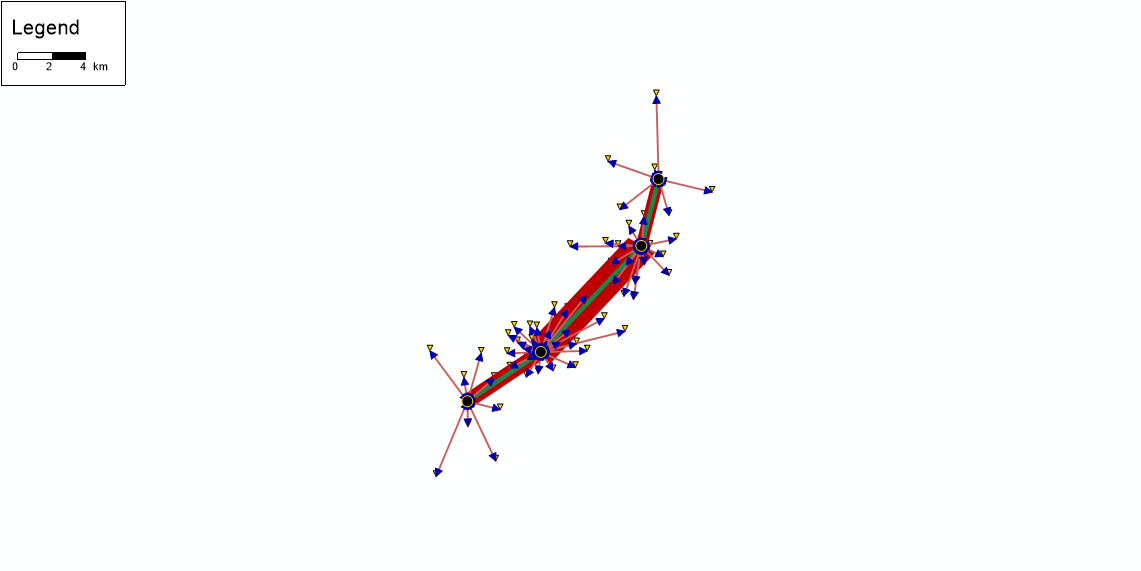


Network after adding the new node


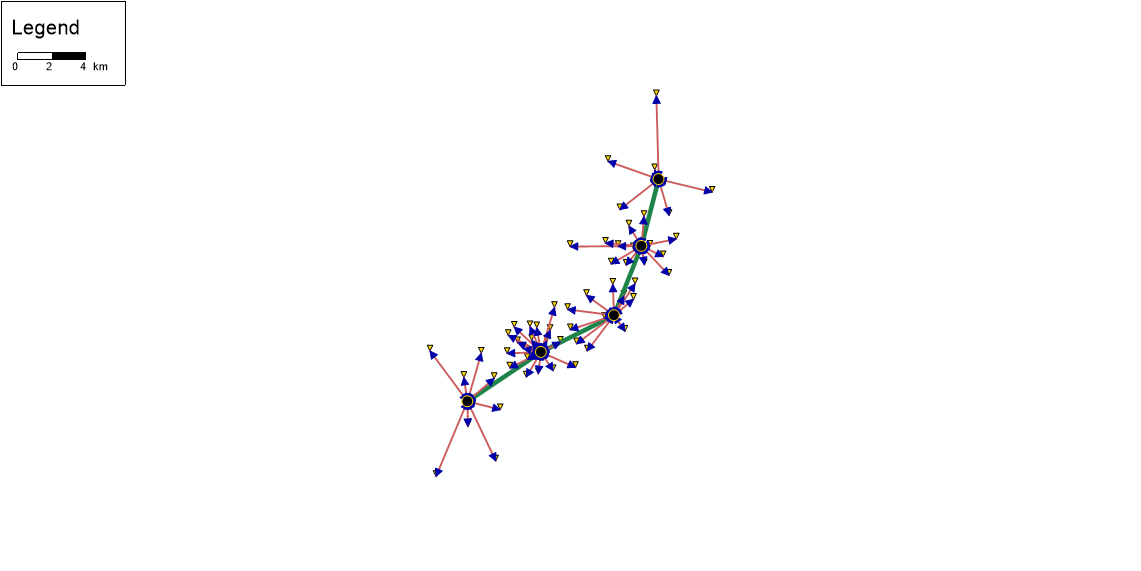

In [11]:
print("Network before adding the new node")
printNetwork("net_8")

#entering edit mode
mod2.StartEditModification()

#doing the modifications
Visum.Net.AddNode(no = node_num, XCoord = x, YCoord = y) #adding new node

#splitting the link via new node
l = Visum.Net.Links.ItemByKey(fromNode = 2, toNode = 3)
l.SplitViaNode(viaNode = node_num)

#updating the connectors
Visum.Net.Connectors.RemoveAll() #to remove all existing connectors
for i in range(len(connector_mod)): #adding new connectors
    Visum.Net.AddConnector(connector_mod["zone_num"][i], connector_mod["to_node"][i])

#exiting edit mode
mod2.EndEditModification()

print("\nNetwork after adding the new node")
printNetwork("net_9")

#### <a id = "extracting-results" style = "color:black">Extracting Results</a>
Like any object in Visum, Scenarios also can be accessed by using `ItemByKey()` method. To extract results from a scenario, first it has to be calculated and then it can be loaded to extract the latest results. `StartCalculation()` method can be used to do the scenario calculations and `LoadResults()` can be used to load the results of a scenario.

Once the `StartCalculation()` method is called, it takes some time to complete the calculations and `LoadResults()` method can not be called within that time. If you call `LoadResults()` within that time Visum will throw an error suggesting that the calculation is still in progress. This means you need to loop through all the scenarios and run `StartCalculation()` for each scenario. And after completing that, you need loop through each scenario again and run `LoadResults()` method. It involves manually running selective lines of code.

Or else, `CALCULATIONSTATE` attribute of scenarios can be checked to see whether the calculation is done or not and if it is not done, we can make the program wait for some time and again check the `CALCULATIONSTATE`. This loop (waiting and checking) continues until the required state (CALCULATED) is achieved and then only `LoadResults()` method will be run for that scenario.

Network after Trip assignment in scenario 1



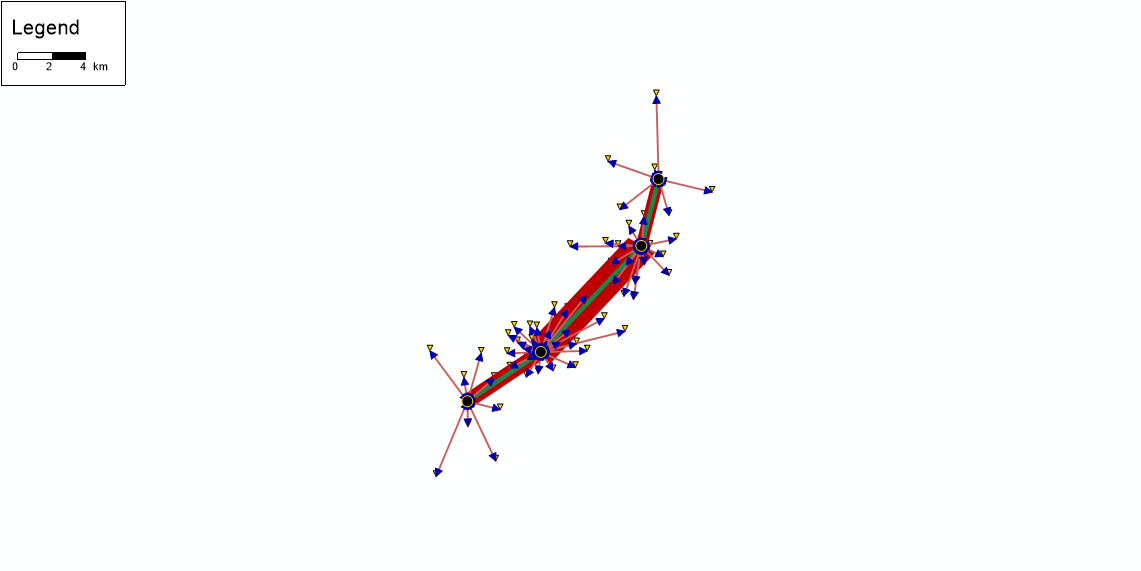

Link Volumes in scenario 1

   from_node  to_node transport_system    length  link_vol_prt
0        1.0      2.0          new_sys  5.189373      517927.2
1        2.0      1.0          new_sys  5.189373      530450.4
2        2.0      3.0          new_sys  8.595852     1023595.2
3        3.0      2.0          new_sys  8.595852     1057773.6
4        3.0      4.0          new_sys  4.093643      394939.2
5        4.0      3.0          new_sys  4.093643      405364.8


Network after Trip assignment in scenario 2



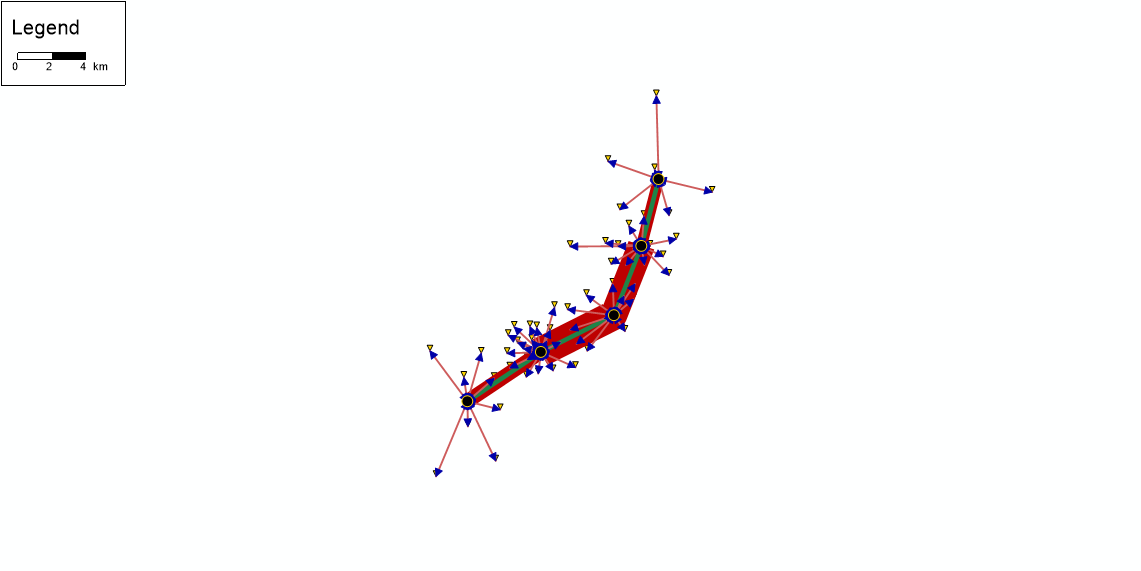

Link Volumes in scenario 2

   from_node  to_node transport_system    length  link_vol_prt
0        1.0      2.0          new_sys  5.189373      517927.2
1        2.0      1.0          new_sys  5.189373      530450.4
2        3.0      4.0          new_sys  4.093643      394939.2
3        4.0      3.0          new_sys  4.093643      405364.8
4        2.0      5.0          new_sys  4.495330     1060372.8
5        5.0      2.0          new_sys  4.495330     1096900.8
6        3.0      5.0          new_sys  4.100522     1000264.8
7        5.0      3.0          new_sys  4.100522      955780.8




In [12]:
sce_count = proj.Scenarios.Count

for i in range(sce_count):
    sce = proj.Scenarios.ItemByKey(i+1)
    
    sce.StartCalculation(CalculationNode='localhost', DownloadResults=True) #calling StartCalculation() method
    
    while sce.AttValue("CALCULATIONSTATE") != 'CALCULATED': #chechking the status of calculation
        time.sleep(2)
        
    sce.LoadResults() #calling LoadResults() only after 'CALCULATED' state is achieved
    
    all_links = Visum.Net.Links.GetMultipleAttributes(
        AttrIDs = ["FROMNODENO", "TONODENO", "TSYSSET", "LENGTH", "VOLVEHPRT(AP)"],
        OnlyActive=False)

    links_df = pd.DataFrame(all_links, columns = ["from_node", "to_node", "transport_system", "length", "link_vol_prt"])
    
    print(f"Network after Trip assignment in scenario {i+1}\n")
    printNetwork(f"net_{10+i}")
    print(f"Link Volumes in scenario {i+1}\n")
    print(links_df)
    print("\n")

The above loop works fine as long as there are no errors in the network. But if there is an issue with the network or with any parameter in Visum then `CALCULATIONSTATE` of a scenario will never become `CALCULATED` which means the while loop will keep running forever.

To rectify this `CALCULATIONSTATE` should be checked for error realted states and if it reaches an error state then we need to break the loop and skip the `LoadResults()` method for that particular scenario.

`error_states` below has main error related states. Below while loop will check `CALCULATIONSTATE` for every 1.5secs and if it is in `error_states` it will break and avoid the `LoadResults()` method or else it will wait until it reaches `CALCULATED` state. This is more dynamic and efficient.

*search for* CALCULATIONSTATE *in COM help manual to see all the states.*

Calculation state of scenario 1: TOCALCULATE
Calculation state of scenario 1: TOCALCULATE
Calculation state of scenario 1: TOCALCULATE
Calculation state of scenario 1: CALCULATED


Network after Trip assignment in scenario 1



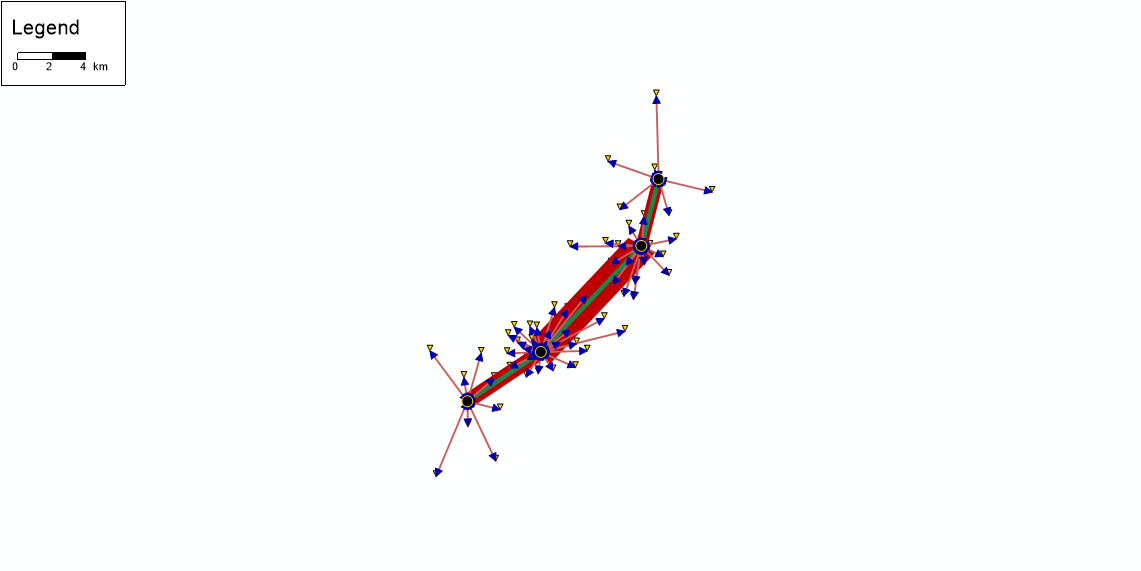

Link Volumes in scenario 1

   from_node  to_node transport_system    length  link_vol_prt
0        1.0      2.0          new_sys  5.189373      517927.2
1        2.0      1.0          new_sys  5.189373      530450.4
2        2.0      3.0          new_sys  8.595852     1023595.2
3        3.0      2.0          new_sys  8.595852     1057773.6
4        3.0      4.0          new_sys  4.093643      394939.2
5        4.0      3.0          new_sys  4.093643      405364.8


Calculation state of scenario 2: TOCALCULATE
Calculation state of scenario 2: TOCALCULATE
Calculation state of scenario 2: TOCALCULATE
Calculation state of scenario 2: CALCULATED


Network after Trip assignment in scenario 2



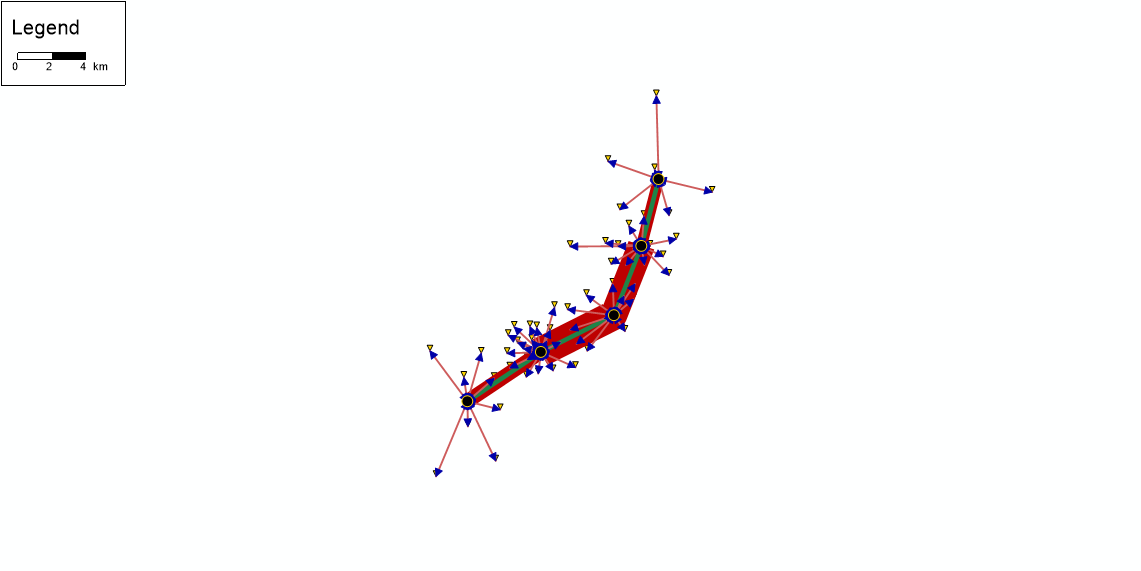

Link Volumes in scenario 2

   from_node  to_node transport_system    length  link_vol_prt
0        1.0      2.0          new_sys  5.189373      517927.2
1        2.0      1.0          new_sys  5.189373      530450.4
2        3.0      4.0          new_sys  4.093643      394939.2
3        4.0      3.0          new_sys  4.093643      405364.8
4        2.0      5.0          new_sys  4.495330     1060372.8
5        5.0      2.0          new_sys  4.495330     1096900.8
6        3.0      5.0          new_sys  4.100522     1000264.8
7        5.0      3.0          new_sys  4.100522      955780.8




In [13]:
#this list was gathered from COM help manual
error_states = ['CANCELLED', 'ERRORDOWNLOAD', 'ERRORDURINGCALCULATION', 'ERRORDURINGCALCULATIONNOTUPTODATE',
               'ERRORUPLOAD', 'UNEXPECTEDLYTERMINATED', 'UNEXPECTEDLYTERMINATEDNOTUPTODATE']

for i in range(sce_count):
    sce = proj.Scenarios.ItemByKey(i+1)
    
    sce.StartCalculation(CalculationNode='localhost', DownloadResults=True)
    
    while sce.AttValue("CALCULATIONSTATE") != 'CALCULATED':
        
        if sce.AttValue("CALCULATIONSTATE") in error_states:
            calculated = False
            print(f'Error message: {sce.AttValue("CALCULATIONSTATE")}')
            break
        time.sleep(1.5)
        
        if sce.AttValue("CALCULATIONSTATE") == 'CALCULATED':
            calculated = True
        
        print(f'Calculation state of scenario {i+1}: {sce.AttValue("CALCULATIONSTATE")}')
    print("\n")
    
    if calculated:
        
        sce.LoadResults()
    
        all_links = Visum.Net.Links.GetMultipleAttributes(
            AttrIDs = ["FROMNODENO", "TONODENO", "TSYSSET", "LENGTH", "VOLVEHPRT(AP)"],
            OnlyActive=False)

        links_df = pd.DataFrame(all_links, columns = ["from_node", "to_node", "transport_system", "length", "link_vol_prt"])
    
        print(f"Network after Trip assignment in scenario {i+1}\n")
        printNetwork(f"net_{12+i}")
        print(f"Link Volumes in scenario {i+1}\n")
        print(links_df)
        print("\n")

In [14]:
#closing the project
Visum.ScenarioManagement.CloseProject()

This may seem a little overwhelming at the beggining but once you get the hang of it you can literally automate everything with Python in Visum and you get to save lots and lots of time and also avoid manual errors.

I hope you learned something new in this tutorial. Happy coding!!!
        
Please feel free to reach out to me on [Linkeding](https://www.linkedin.com/in/pamidiashok/) for any queries or suggestions.